# Explore

This file is used to get familiar with the environment and pyroomacoustics. The audio dataset that is used comes from:
[CMU ARCTIC](http://www.festvox.org/cmu_arctic/)

Initially, create a simple room and add microphones and sound sources

(0.0, 4.0)

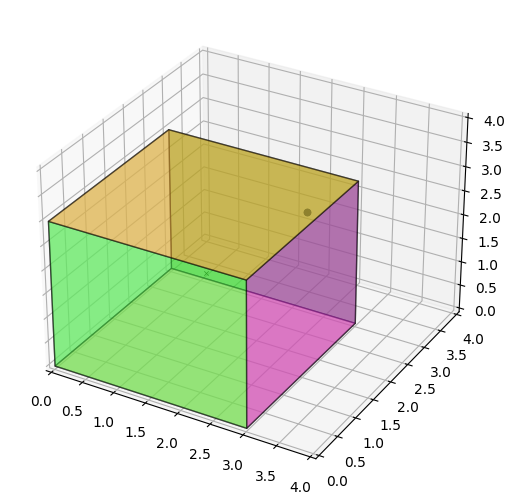

In [1]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import math

# specify signal source
fs, signal = wavfile.read("..\\data\\original\\arctic_a0010.wav")

# generate 2D room
corners = np.array([[0,0], [0,3.], [3.,3.], [3.,0]]).T  # [x,y]
room = pra.Room.from_corners(corners, fs=fs, max_order=3)
room.extrude(3.)

# add sound source to room
room.add_source([2.5,2.5,2.5], signal=signal)

# add microphone
mic_loc = [1.5, 1.5, 1.5]
room.add_microphone(mic_loc)

fig, ax = room.plot()
ax.set_xlim([0, 4])
ax.set_ylim([0, 4])
ax.set_zlim([0, 4])

Apply ray tracing to the room and get the room impulse response (RIR). The rays start at the sound source, and are all emitted in uniformly random directions at the same time, travelling at the speed of sound.

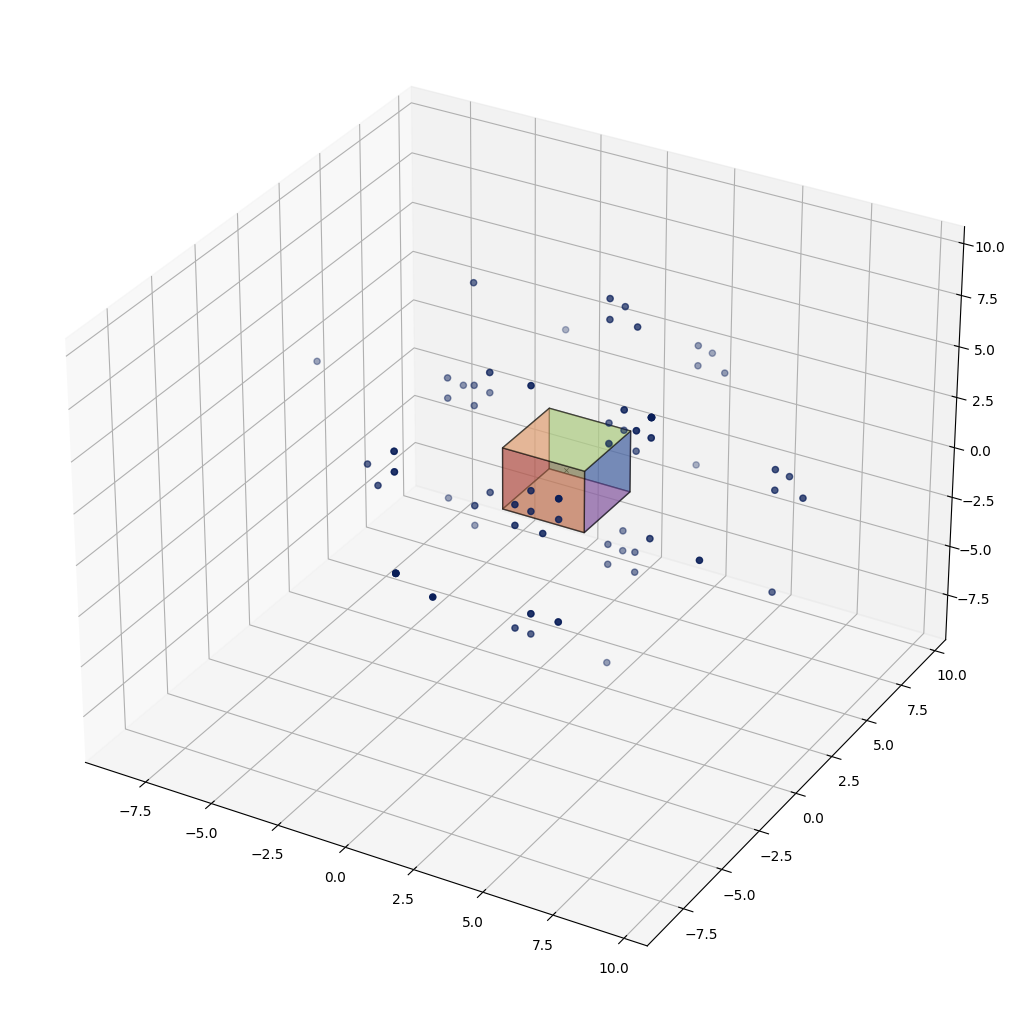

In [2]:
# Set the ray tracing parameters
#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# compute image sources
room.image_source_model()

# visualize 3D polyhedron room and image sources
fig, ax = room.plot()
fig.set_size_inches(20, 10)

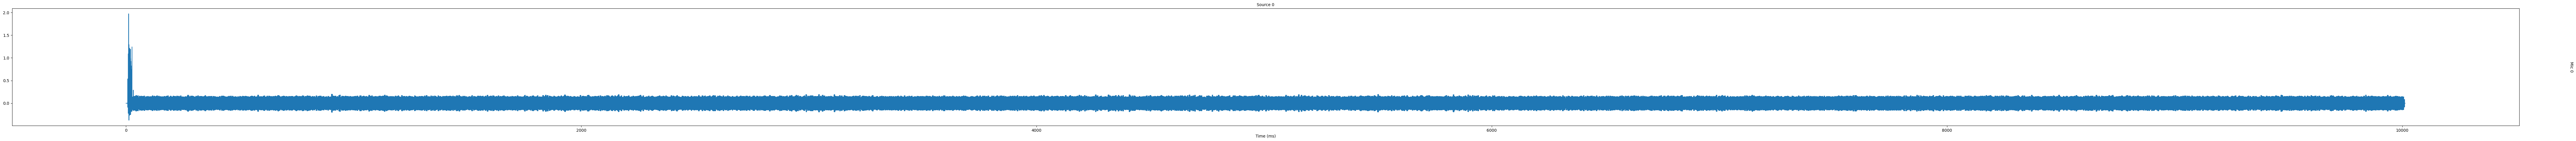

In [10]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(100, 5)

Add noise to the room by decreasing the signal-to-noise ratio (SNR). Simulate the room and calculate the reverberation time (RT60). Wang Brown in 'Computational Audiotory Scene Analysis' states that the SNR should be kept above 10dB in order for the sound to be somehow intelligebla.

In order to calculate the SNR in dB:
SNR = 10log10(K/sigma^2) where K-number sources and sigma is the variance of the noise

In [6]:
snr = 10*math.log10(room.n_mics/0.001)
print(snr)

room.simulate(reference_mic=0, snr=snr)

30.0


The RT60 is 14 ms


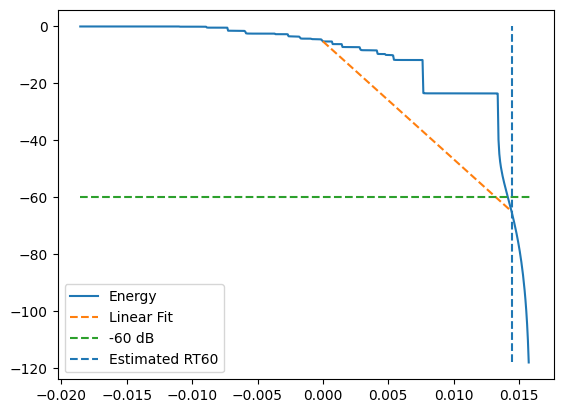

In [6]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

Check the sound before and after the room simulation

In [4]:
# original signal
print("Original WAV:")
IPython.display.Audio(signal, rate=fs)

Original WAV:


In [7]:
print("Simulated propagation to first mic:")
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

Simulated propagation to first mic:


Pyroomacoustics has some standard mathematical models that can estimate this (SRP-PHAT, MUSIC, CSSM, WAVES, TOPS, and FRIDA)

In [9]:
# Location of source
azimuth = np.array([180.]) / 180. * np.pi # convert degree to radians
distance = 1.5  # meters

c = 343.                                                    # speed of sound
fs = 16000                                                  # sampling frequency
nfft = 256                                                  # Fast Fourier Transform size
freq_range = [300, 3500]
snr_db = 10.                                                 # signal-to-noise ratio
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * distance)**2    # noise variance

# Create an anechoic room
room_dim = np.r_[5.,5.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=3, ray_tracing=True, sigma2_awgn=sigma2)
aroom.extrude(2.)
aroom.set_ray_tracing(receiver_radius=0.25, n_rays=2500, energy_thres=1e-8)

# add microphone
microphones = np.c_[[2.55, 2.55, 1.],[ 2.45, 2.45, 1.]]

# add sources
rng = np.random.RandomState(23)
duration_samples = int(fs)
source_location = room_dim / 2 + distance * np.r_[np.cos(azimuth), np.sin(azimuth)]
source_signal = rng.randn(duration_samples)
aroom.add_source(np.append(source_location, 1.), signal=source_signal)

aroom.add_microphone_array(microphones)

# Run the simulation
aroom.simulate()

In [13]:
# The DOA algorithms require an short-time Fourier transform input, 
# which is computed for overlapping frames for the 1 second duration signal.

# Size should be M x F x S, where M should correspond to the
# number of microphones, F to nfft/2+1, and S to the number of snapshots
# (user-defined). It is recommended to have S >> M.
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

In [14]:
algo_names = ['MUSIC', 'TOPS']
spatial_resp = dict()

# loop through algos
for algo_name in algo_names:
    # Construct the new DOA object
    doa = pra.doa.algorithms[algo_name](microphones, fs, nfft, c=c, num_src=1)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=freq_range)
    
    # store spatial response
    spatial_resp[algo_name] = doa.grid.values
        
    # normalize   
    min_val = spatial_resp[algo_name].min()
    max_val = spatial_resp[algo_name].max()
    spatial_resp[algo_name] = (spatial_resp[algo_name] - min_val) / (max_val - min_val)

(0.0, 11.55)

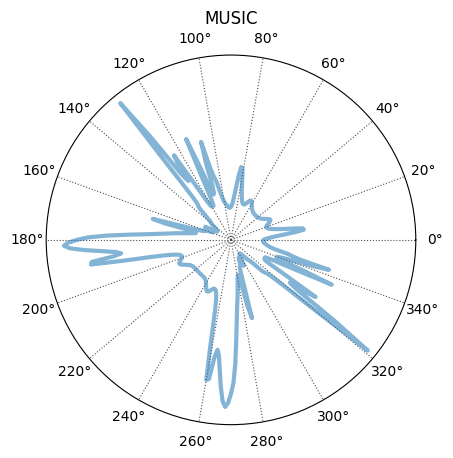

In [15]:
spatial_resp = None
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

# Construct the new DOA object and perform localization on the frames in X
doa = pra.doa.algorithms['MUSIC'](microphones, fs, nfft, c=c, num_src=1)
doa.locate_sources(X, freq_range=freq_range)
spatial_resp = doa.grid.values  
min_val = spatial_resp.min()
max_val = spatial_resp.max()
spatial_resp = (spatial_resp - min_val) / (max_val - min_val)

# Vizualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

phi_plt = doa.grid.azimuth
c_phi_plt = np.r_[phi_plt, phi_plt[0]]
c_dirty_img = np.r_[spatial_resp, spatial_resp[0]]

ax.plot(c_phi_plt, 1 + 10 * c_dirty_img, linewidth=3, alpha=0.55, linestyle='-', label="spectrum")
plt.title('MUSIC')
ax.set_xticks(np.linspace(0, 2 * np.pi, num=18, endpoint=False))
ax.set_yticks(np.linspace(0, 0, 0))
ax.xaxis.grid(visible=True, color=[0.3, 0.3, 0.3], linestyle=':')
ax.set_ylim([0, 1.05*(10 + 1)])

In [11]:
import cv2
import os

image_folder = '../pygame/path_ideal/'
video_name = 'video_ideal.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()